## EDA in SAS on Titanic data by Michael Eryan

### Setup and import the data.

In [38]:
options nosource nonotes; * avoid most of the log output ;

libname t "/folders/myfolders/";

%let input=titanic_data.csv;
%let dataset=titanic;

/*
FILENAME REFFILE '/folders/myfolders/titanic_data.csv';
PROC IMPORT DATAFILE=REFFILE
	DBMS=CSV REPLACE
	OUT=t.titanic;
	GETNAMES=YES;
RUN;
*/

### General data set examination and preparation
 
Add the variable "Minor" and load the data set into macro variables to avoid typos.
The data is a sample and incomplete, so we cannot make any generalizations or definitive conclusions. My goal is just exploration, observation and some speculation.

In [39]:
proc sql;
create table titanic as
select
*
,case when age is not null then 
	(case when age < 18 then 1 else 0 end)
	else . end as minor
from t.titanic
;quit;

### Automatically produced summary of the data set
The input data set is titanic_data.csv.
Proc Contents provides all the info about the data set.

In [40]:
ods select Attributes Variables ;
proc contents data=&dataset ;
run;
ods select default;

Print a few rows of the data set

In [41]:
proc print data=&dataset (obs=10);
run;

Obs,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,minor
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S,0
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,0
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S,0
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,0
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S,0
6,6,0,3,"Moran, Mr. James",male,.,0,0,330877,8.4583,,Q,.
7,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,0
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S,1
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S,0
10,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C,1


Print a summary of all the numerical variables in the data

In [42]:
proc means data=&dataset n nmiss min mean median max range std fw=8 maxdec=2;
run;

Variable,N,N Miss,Minimum,Mean,Median,Maximum,Range,Std Dev
PassengerId Survived Pclass Age SibSp Parch Fare minor,891 891 891 714 891 891 891 714,0 0 0 177 0 0 0 177,1.00 0.00 1.00 0.42 0.00 0.00 0.00 0.00,446.00 0.38 2.31 29.70 0.52 0.38 32.20 0.16,446.00 0.00 3.00 28.00 0.00 0.00 14.45 0.00,891.00 1.00 3.00 80.00 8.00 6.00 512.33 1.00,890.00 1.00 2.00 79.58 8.00 6.00 512.33 1.00,257.35 0.49 0.84 14.53 1.10 0.81 49.69 0.37


### Univariate Plots and Analysis
Single variable tabulations

In [43]:
proc format;
	value survfmt 1="Survived" 0="Died";
	value $sexfmt  "male"="1_Male" "female"="2_Female";
run;

proc sql;
select survived,count(*) as count from &dataset group by 1;
select sex,count(*) as count from &dataset group by 1;
select pclass,count(*) as count from &dataset group by 1;
select minor,count(*) as count from &dataset group by 1;
quit;

Survived,count
0,549
1,342
Sex,count
female,314
male,577
Pclass,count
1,216
2,184
3,491
minor,count


### Bar Charts


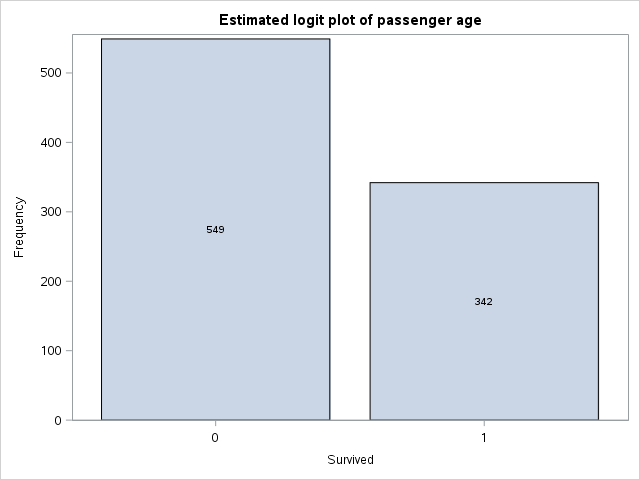
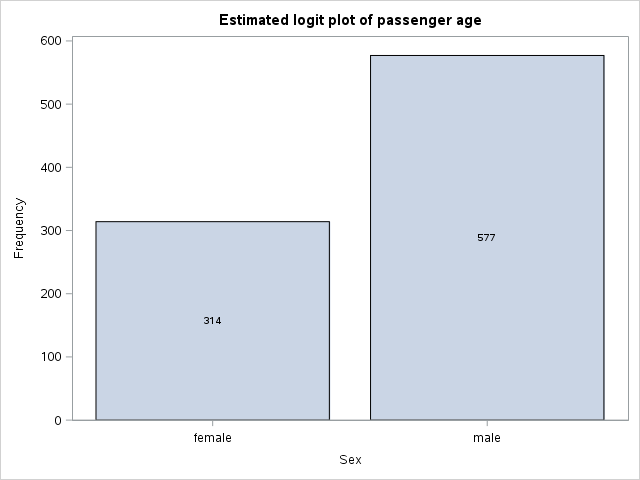
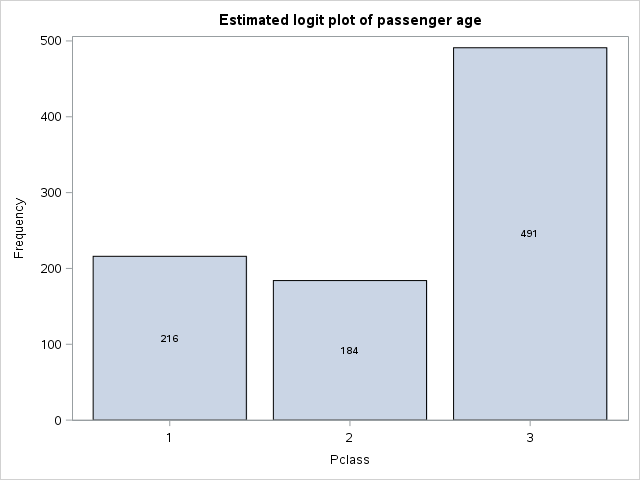
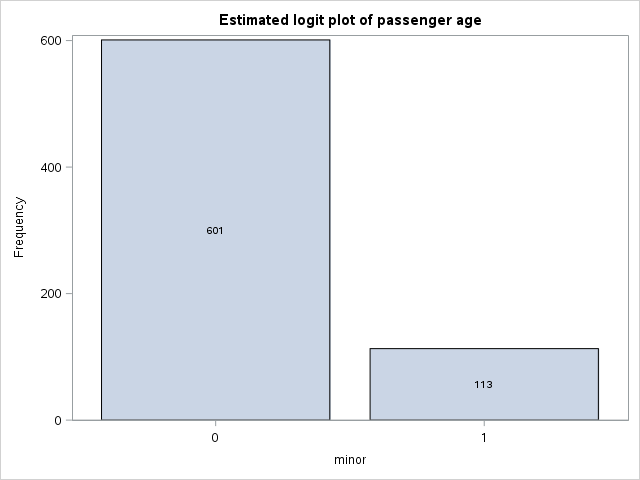

In [44]:
proc sgplot data=&dataset ;                                                                                                                 
   vbar survived / seglabel;                                                                                                         
run; 
proc sgplot data=&dataset;                                                                                                                 
   vbar sex / seglabel;                                                                                                        
run; 
proc sgplot data=&dataset;                                                                                                                 
   vbar pclass / seglabel;                                                                                                         
run; 
proc sgplot data=&dataset;                                                                                                                 
   vbar minor / seglabel;                                                                                                       
run; 

Observations: more males than females, more died than survived, 3 is the poorest socio-econ class.
 
### Fancier bar charts - Counts and Proportions of Gender vs Survival.


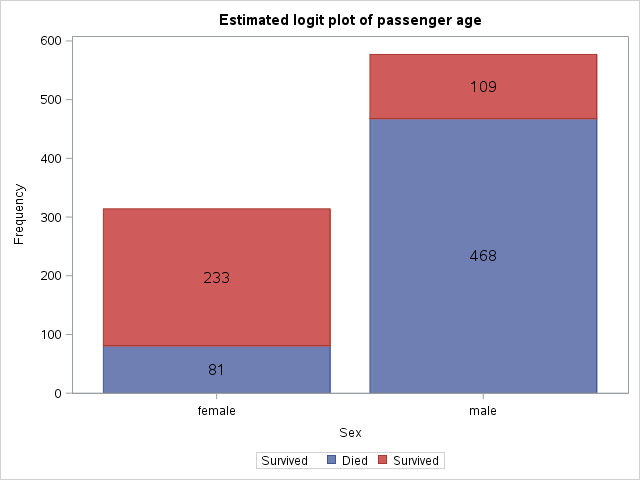

In [45]:
proc sgplot data=&dataset;                                                                                                                 
   vbar sex / group=survived seglabel seglabelattrs=(size=12);
   format survived survfmt.;                                                                                                         
run; 

### Histogram with Density Plot of Age


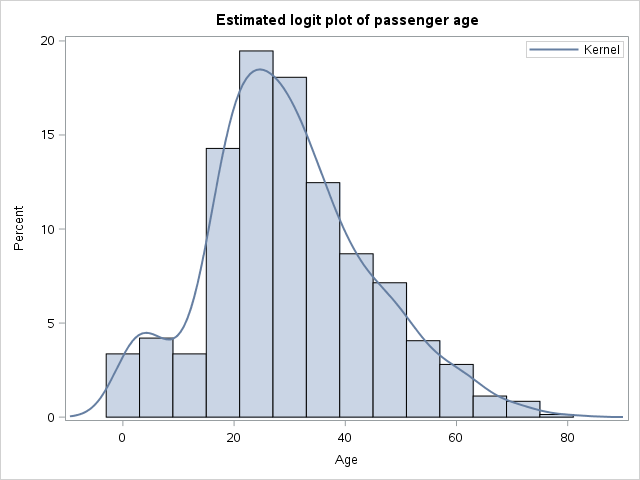

In [46]:
proc sgplot data=&dataset;                                                                                                                 
   histogram age ;
   density age / type=kernel; 
   keylegend / location=inside position=topright;                                                                                                      
run; 

### Bivariate Plots and Analysis
Let’s facet Age by Sex and Survival


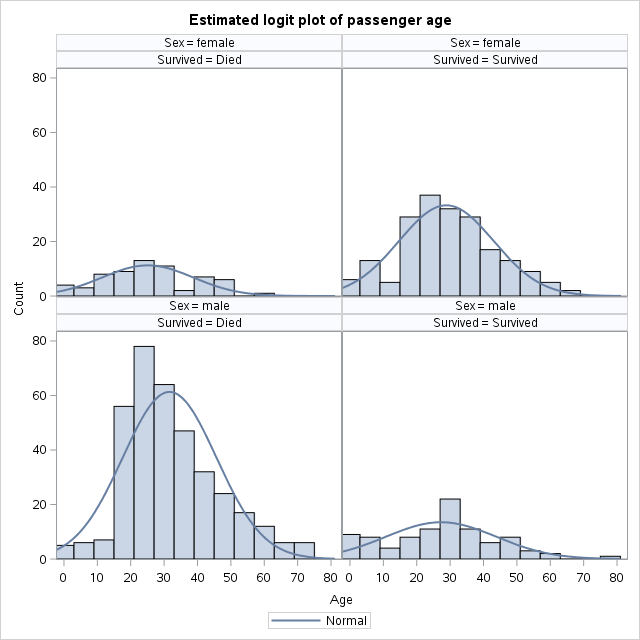

In [47]:
proc sgpanel data = &dataset;
  panelby sex survived / columns = 2 rows =2;
  histogram age / scale=count;
  density age ;
  colaxis values= (0 to 80 by 5);
  format survived survfmt.;
run;

Almost mirror image, but is it statistically significant? Let’s test by Anova.


First, let's look at the mean of Age by gender*survival.

In [48]:
proc sql;
select sex,survived,mean(age) as mean_age
from &dataset
group by 1,2
order by 2,1 desc
;quit;

Sex,Survived,mean_age
male,0,31.61806
female,0,25.04688
male,1,27.27602
female,1,28.84772


For survivors, the means are pretty close, but not so for dead. But is it significant?

In [49]:
data t1;
set &dataset;
where survived=1;
run;

ods select OverallANOVA;
proc anova data=t1 plots=none;
	class sex;
	model Age = sex;
run;

Source,DF,Sum of Squares,Mean Square,F Value,Pr > F
Model,1,156.05845,156.05845,0.70,0.4043
Error,288,64444.39050,223.76524,,
Corrected Total,289,64600.44895,,,


Age difference is not significant among the survivors.

In [50]:
data t0;
set &dataset;
where survived=0;
run;
ods select OverallANOVA;
proc anova data=t0 plots=none;
	class sex;
	model Age = sex;
run;
ods select default;

Source,DF,Sum of Squares,Mean Square,F Value,Pr > F
Model,1,2346.40740,2346.40740,11.99,0.0006
Error,422,82612.59201,195.76444,,
Corrected Total,423,84958.99941,,,


But definitely significant among the dead.
Yes, the difference in age by sex is definitely significant.
The men who died were older than the women who died.


Let’s look closer at survival * sex * pclass


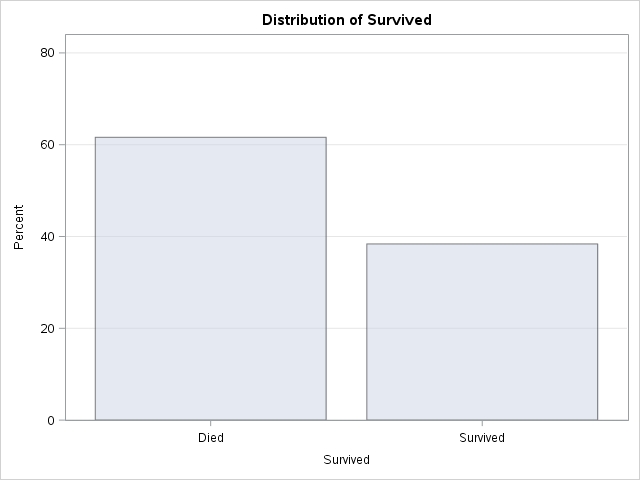
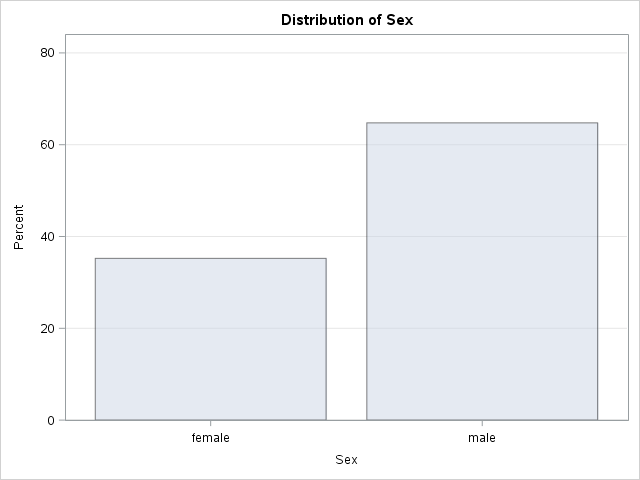
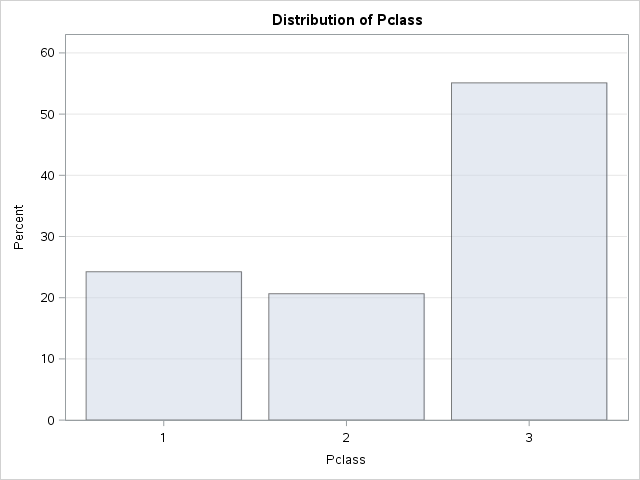
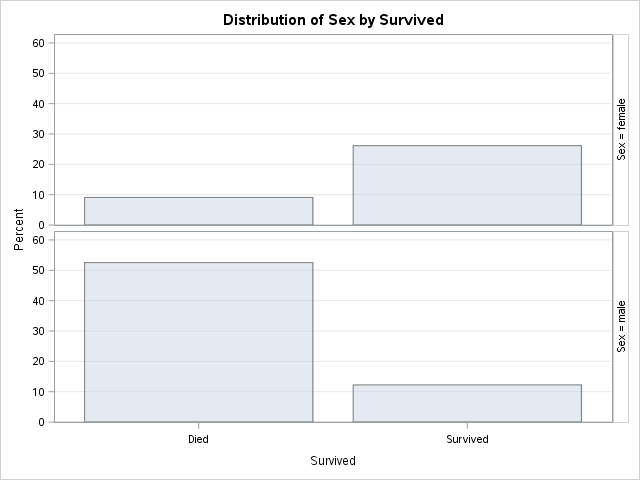
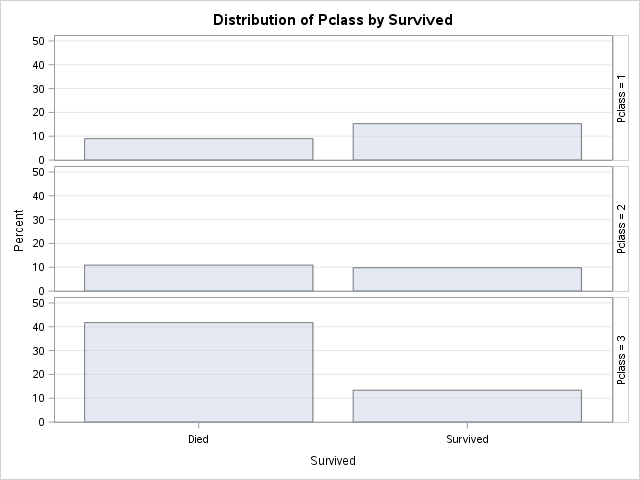

In [51]:
proc freq data=&dataset;
	tables survived sex pclass
			sex * survived pclass*survived / 
			plots (only)=freqplot(scale=percent);
	format survived survfmt.;
run;

We see that there might be a link between being male and not surviving.
Let's do a test for association (contingency table test).

Hypothesis: There is an association between sex and survival	also try class and age.

In [52]:
proc freq data=&dataset;
	tables 
			(sex pclass) * survived  / 
			chisq expected cellchi2 nocol nopercent relrisk;
	format survived survfmt.;
run;

Odds ratio (top row/bottom row) is significant at 0.08 - women are more likely than men to survive.
0.08 says that a female has about 8 of the odds of dying compared to a male.
Alternatively males have 92 lower odds of surviving than females.

Does this pattern hold among the minors?

In [53]:
proc freq data=&dataset;
	tables 
			sex  * survived  / 
			chisq expected cellchi2 nocol nopercent relrisk;
	where minor=1;
	format survived survfmt.;
run;

Yes, it does.


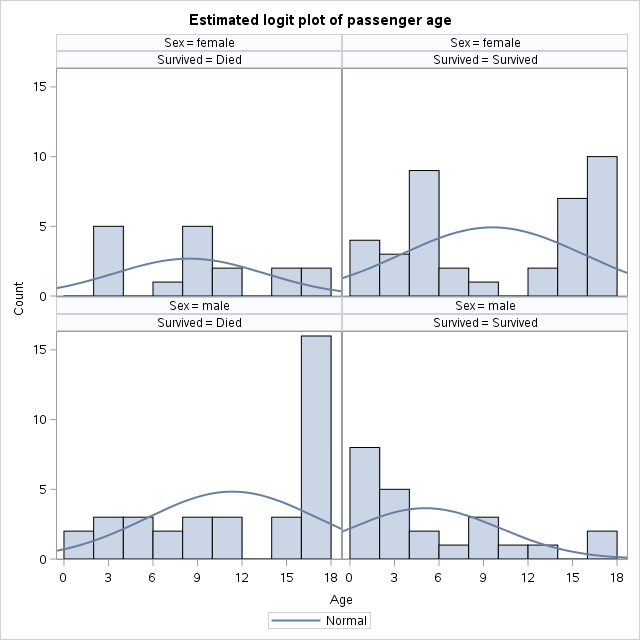
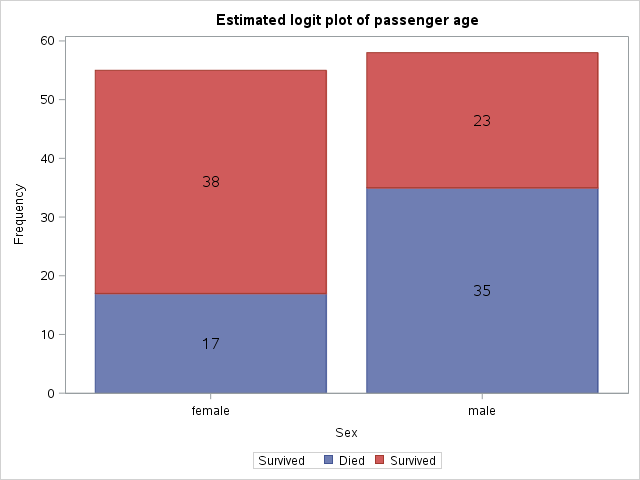

In [54]:
proc sgpanel data = &dataset;
  panelby sex survived / columns = 2 rows =2;
  histogram age / scale=count;
  density age ;
  colaxis values= (0 to 18 by 3);
  where minor=1;
  format survived survfmt.;
run;
proc sgplot data=&dataset;                                                                                                                 
   vbar sex / group=survived seglabel seglabelattrs=(size=12);
   where minor=1;
   format survived survfmt.;                                                                                                         
run; 

Looks similiar to the overall chart above. Shows that Minor or not, males were still less likely to survive.
 
Detecting Ordinal Associations - survival and socio-economic class.

In [55]:
proc freq data=&dataset;
	tables 
			pclass * survived  / 
			chisq measures cl;
	format survived survfmt.;
run;

Yes, there is a relationsip between class and survival chisq is significant and spearman is -0.3397.


### Multivariate Plots And Analysis
Distribution of survival by age faceted by gender


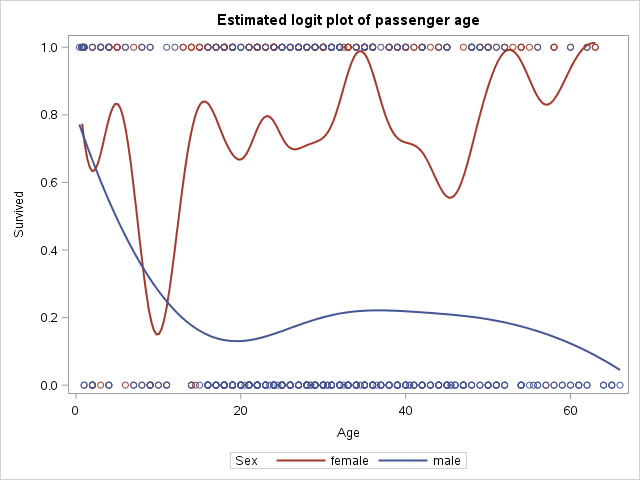

In [56]:
proc sgplot data=&dataset;
 	pbspline x=age y=survived / group=sex; 
 	where age <70;          
run;

Does not look very similiar to R's plot, but proves the same point.

Let’s build a Linear probability model first.


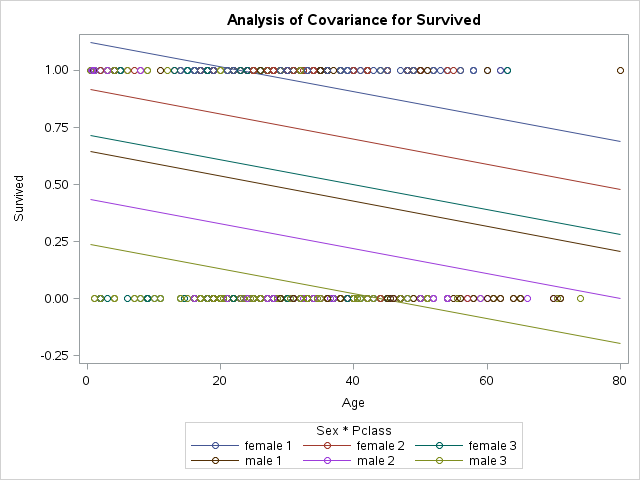

In [57]:
proc glm data=&dataset alpha=0.5;
	class sex pclass;
	model survived  = age sex pclass /solution;
	title 'Linear probability model: survived  = age sex pclass';
run;

Signs make sense: Age has a negative sign, being female has a positive sign, being of higher social class has a positive sign on probability of survival.

Let’s build a logistic regression and get the odds as well.


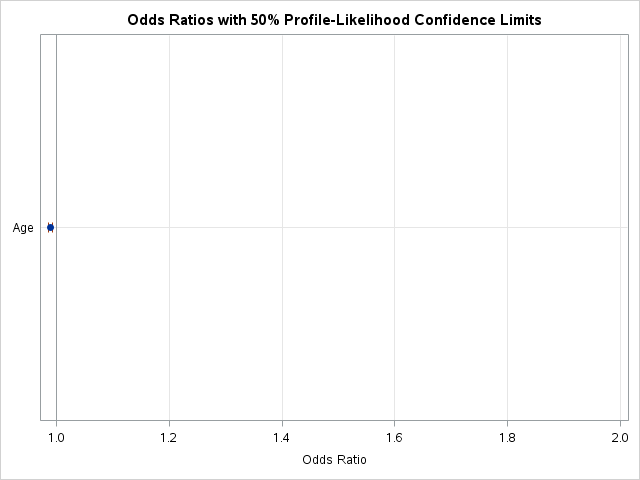
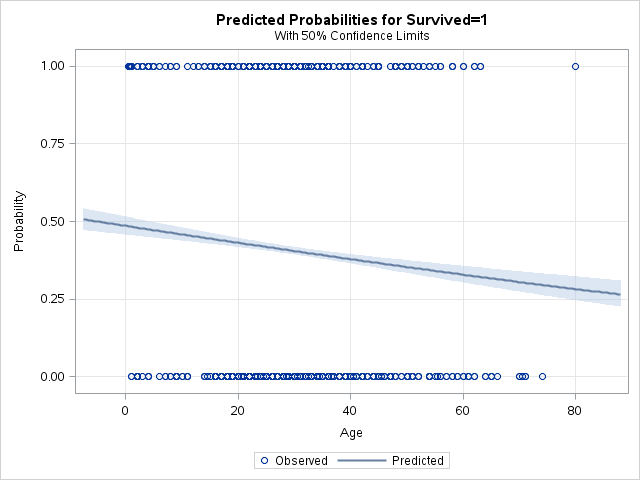

In [58]:
proc logistic data=&dataset alpha=0.5
	plots (only) = (effect oddsratio);
	model survived (event='1') = age / clodds=pl;
	title 'Logistic Model (1): survived=age';
run;

Odds ratio is 0.992 - so by increasing age by 1 year we decrease odds of surviving by 0.8.
 
Logistic model with a categorical predictor.


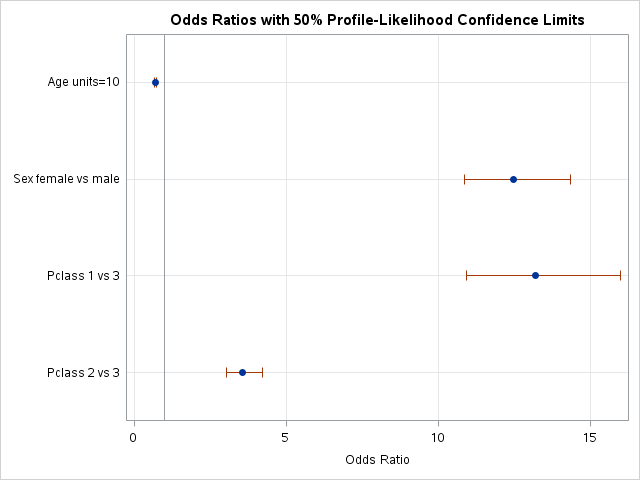
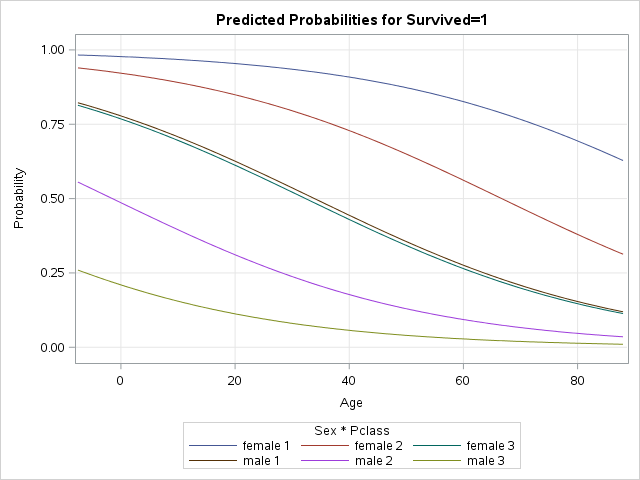

In [59]:
proc logistic data=&dataset alpha=0.5
	plots (only) = (effect oddsratio);
	class sex(ref='male') pclass(ref='3') / param=ref;
	model survived (event='1') = age sex pclass / clodds=pl;
	units age=10;
	title 'Logistic Model (2): survived=age sex class';
run;

Interpretation of odds ratios: Increasing age by 10 years decreases the odds of surviving by 0.691, going from male to female increases the odds by 12.463, going from Pllass=3 to 1 increases the odds by 13.205 etc.
 
Logistic regression: backward elimination with interactions.


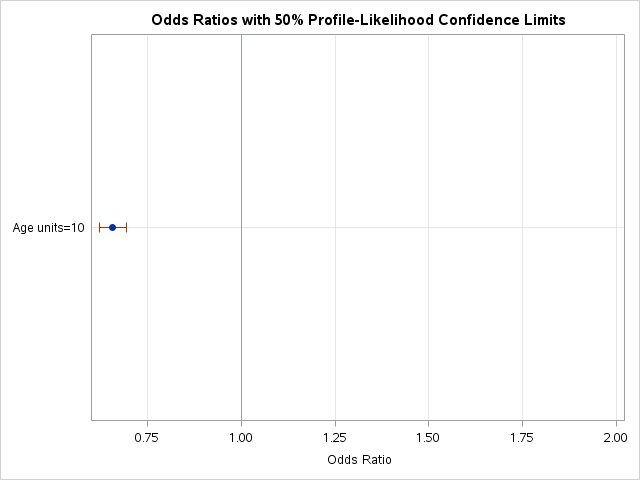
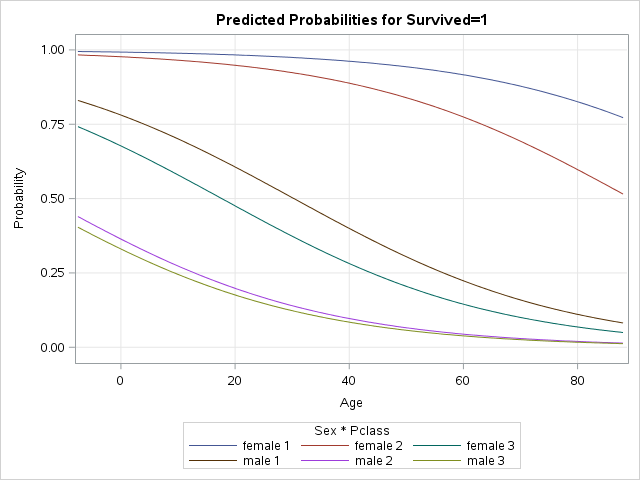

In [60]:
proc logistic data=&dataset alpha=0.5
	plots (only) = (effect oddsratio);
	class sex(ref='male') pclass(ref='3') / param=ref;
	model survived (event='1') = age|sex|pclass @2/ selection=backward slstay=0.01 clodds=pl;
	units age=10;
	title 'Logistic Model (3): Backward elimination, survived=age sex class';
run;

Plot empirical estimated logits - to verify if the assumption of linear holds.


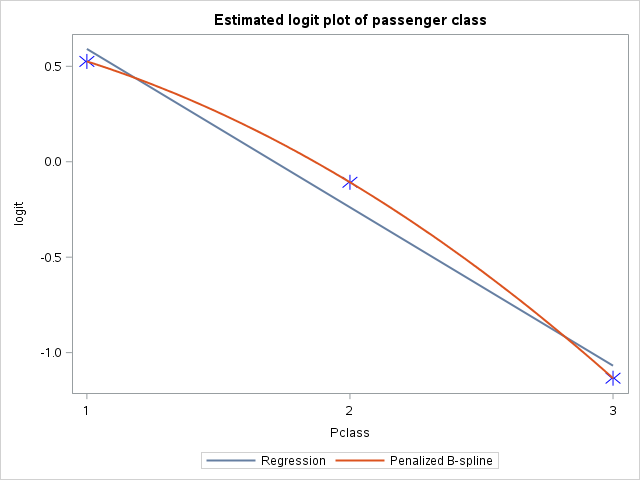

In [61]:
proc means data=&dataset noprint nway;
	class pclass;
	var survived;
	output out=bins1 sum(survived)=nevent n(survived)=ncases;
run;
data bins2;
	set bins1;
	logit=log((nevent + 1)/(ncases - nevent+1));
run;
proc sgplot data=bins2;
	reg y=logit x=pclass / markerattrs=(symbol=asterisk color=blue size=15);
	pbspline y=logit x=pclass / nomarkers;
	xaxis integer;
	title "Estimated logit plot of passenger class";
run;
quit;

Looks sort of linear, so logistic regression is applicable.
Same but for a continuous variable - bin into 50 groups of at least 20 obs to have enough obs for logit.


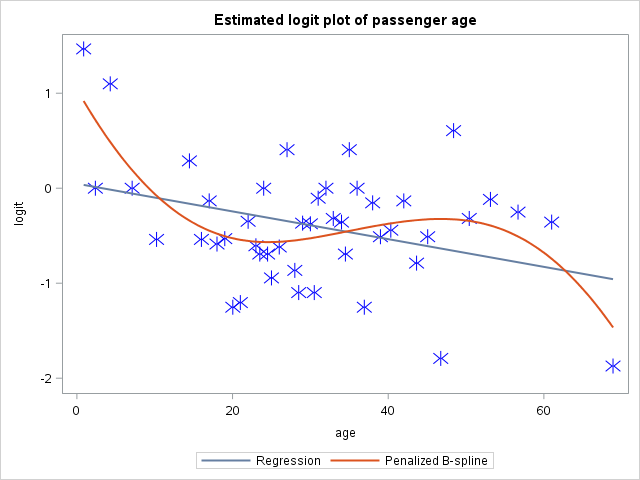

In [62]:
proc rank data=&dataset groups=50 out=ranks;
	var age;
	ranks Rank;
run;
proc means data=ranks noprint nway;
	class rank;
	var survived age;
	output out=bins3 sum(survived)=nevent n(survived)=ncases mean(age)=age;
run;
data bins4;
	set bins3;
	logit=log((nevent + 1)/(ncases - nevent+1));
run;
proc sgplot data=bins4;
	reg y=logit x=age/ markerattrs=(symbol=asterisk color=blue size=15);
	pbspline y=logit x=age/ nomarkers;
	xaxis integer;
	title "Estimated logit plot of passenger age";
run;
quit;

Nonlinearity detected - perhaps we need to transform Age before plugging into a logistic regression.
 
 
### Final Plots and Summary.
Plot One: Bar chart of Survived and Gender.

Survived,count,percent
0,549,62%
1,342,38%
Sex,count,percent
male,577,65%
female,314,35%

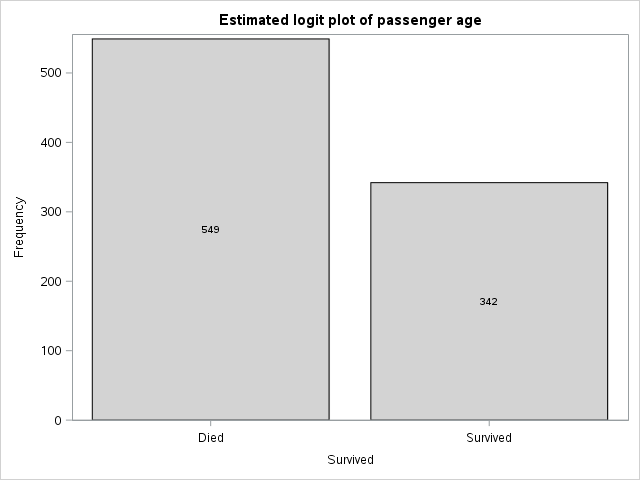
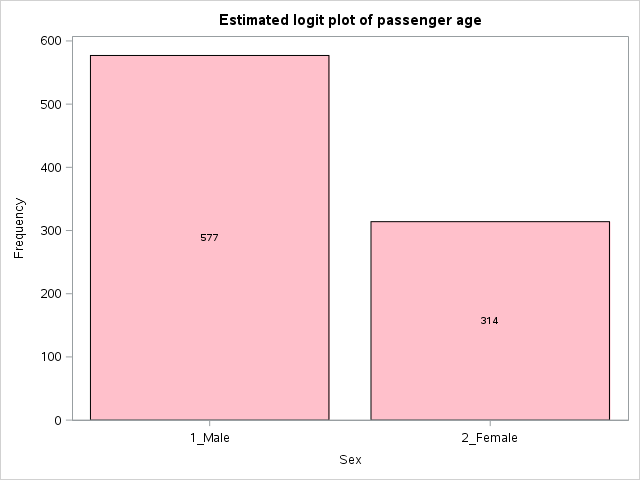

In [63]:
proc sgplot data=&dataset;                                                                                                                 
   vbar survived / seglabel fillattrs= (color= lightgrey);
   xaxis discreteorder=formatted; 
   format survived survfmt.;                                                                                                        
run; 
proc sgplot data=&dataset ;                                                                                                                 
   vbar sex / seglabel fillattrs= (color= pink);
   xaxis discreteorder=formatted; 
   format sex $sexfmt.;                                                                                                        
run; 

proc sql noprint;
select count(*) into :total from &dataset;
quit;
proc sql;
select survived,count(*) as count, count(*) / &total  as percent format=percent10. from &dataset group by 1;
select sex,count(*) as count, count(*) / &total  as percent format=percent10. from &dataset group by 1 order by sex desc;
quit;

Plot One Discussion.
Interesting, the distributions of Survived and Sex are almost identical.
That is 65pct of passengers were male and 62pct of passengers did not survive.
Is there a link between being male and not surviving?
 
Plot Two: Distribution of Age by Survived separately by Sex.


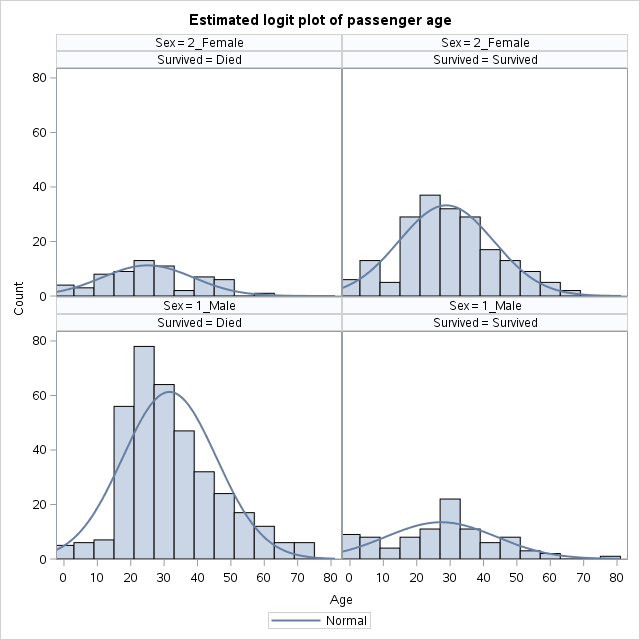

In [64]:
proc sgpanel data = &dataset;
  panelby sex survived / columns = 2 rows =2;
  histogram age / scale=count;
  density age ;
  colaxis values= (0 to 80 by 5);
  format survived survfmt. sex $sexfmt.;
run;

Plot Two Discussion.
This plot looks like a mirror image: most of men did not survive, while most women did.

Plot Three: Linear probability model by Sex.


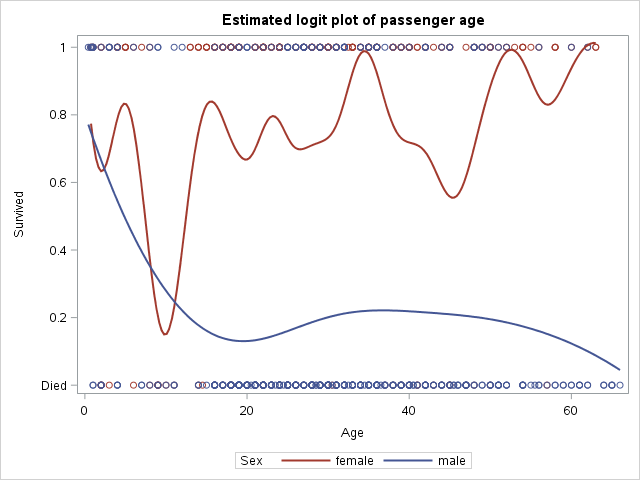

In [65]:
proc sgplot data=&dataset;
 	pbspline x=age y=survived / group=sex;   
 	format survived survfmt. ;
 	where age <70;        
run;

Plot Three Discussion.

The blue line can be interpreted as the predicted probability of surviving by age. For men this probability falls rapidly at 15 years old and stays pretty low. For women of all ages the probability of surviving is much higher.
 
### Issues, Reflections, Conclusions (Speculations)
 
Issues: What we have is an incomplete data set - obviously there were more than 891 passengers on Titanic. We can make no assumptions about whether we got a random sample or a biased one. Therefore we cannot really make any general conclusions but we can speculate about the results.

There is missing data for Age. I did no imputations because I cannot make any assumptions whether the values are MCAR (missing completely at random). Those observations were just dropped by the R’s procedures when Age variable was invovled.
My exploratory data analysis suggested a link between survival and gender, so I pursued this and conducted statistical tests.
Chi-squared test of the frequency of survival based on gender (Sex) returned a very low p-value meaning this pattern could not have occurred by chance.

Both the linear and logistic probability models returned negative estimates for being male on survival.
The odds ratio of survival of being female comparing to being a male was 12.5.
This means that females were 12 times more likely to survive that males.

This pattern holds even for minors (<18 years old) - females were still more likely to survive.
This seems to suggest that in the good old saying “women and children first” boys of 15 years or older do not count as “children.”
Next steps? In the future I could review other tragic events and disasters and analyze factors that influence the probability of survival.
 
### Appendix: Data Dictionary
Data source: https://www.kaggle.com/c/titanic/data
 
VARIABLE DESCRIPTIONS:

survival Survival
(0 = No; 1 = Yes)
pclass Passenger Class
(1 = 1st; 2 = 2nd; 3 = 3rd)
name Name
sex Sex
age Age
sibsp Number of Siblings/Spouses Aboard
parch Number of Parents/Children Aboard
ticket Ticket Number
fare Passenger Fare
cabin Cabin
embarked Port of Embarkation
(C = Cherbourg; Q = Queenstown; S = Southampton)
 
 
The End.